# Setup

Need to setup and turn on the Julia server in background before starting:

((Add instructions for this here))

Set gpolicies globally. (Usually this will remain the same throughout a long set of runs.)

```
gpolicies = Dict(:ptw => ALSimAs.ptw_policy, :ts => ALSims.ts_policy, 
                 :ucb => ALSims.ucb_policy, :ura => ALSims.ura_policy)
                 
```

If you don't already have previous results saved in "~/results/al_results.serialized", 
then you need to create that directory in your home, and do:

```
#DO NOT DO THIS IF YOU ALREADY HAVE RESULTS, USE ```bkupresults()``` instead:
serialize(resultfile("al_results.serialized"),[])
```

(See more on storage, below)

# Running

See run(...). 

The model for interactions at the moment is that you have to say: int_flag=true, and then the bm x tx interactions will be automatically included. 

# Results storage

The way this works at the moment, is that whenever run(...) is called, the result 
is pushed on the front of gresults[] and then this is serialized into a file called 
"~/results/al_results.serialized".

gresults will get auto-loaded when you run if it is null.

The advantage of this, and the reason is was done this way, is that you'll generally run a few
experiments, and then want to compare the results, using plotrun([x,y,z,...]) to create a grided display of the results.

The disadvantage is that gresults gets big, and takes a long time to (de)serialize. Therefore, there is a function called 
```bkupresults(label="astring")``` that moves the current results to a labelled and time-stamped file, and clears them. 
In order to get them back, at 
the moment you have to manually mv the desired timestamped file back into al_results.serialized and reload it. 
(Obviously there should be a restore() function, but this whole scheme is getting thrown out soon anyway, so this is fine
for the moment.)

The clobberesults(n) function removes the nth result (per listersults() numbering). It does NOT, however, actually re-save gresults,
so if you below it, you have a change to recover by reloading gresults using:

```
gresults = deserialize(resultfile("al_results.serialized"))
```

The next time you run(), gresults wiil be dumped, so any clobbering you've done will become permanent at that time!

Warning: Some of the most destructive functions have an annoying required really=true argument...for obvious reasons! :-)

# Plotting results

Run() plots its one result, but plotrun(...) will plot a desired result.  Listresults() show the loaded results (in gresults), and 
then plotrun(n) will plot the nth gresult (1 being the latest/top/first one). If you give plotrun(...) an arrary argument, like:
plotrun([3,2,4,5,6]), it will grid the plots in left-to-right, top-to-bottom order. The optional keyword argument: figsize=(n,m) 

In [ ]:
cd(string(homedir(),"/active_learning/alsims")

In [41]:
using Pkg
Pkg.activate("ALSims.jl")
using ProgressMeter
using ALSims
using PyPlot; const plt = PyPlot
using Statistics
using Printf
using Serialization
using Dates

 Activating environment at `~/active_learning/alsims/ALSims.jl/Project.toml`


In [321]:
# This will eventually be set in the Model code.
gmodel_version = string(Dates.format(now(),"yyyymmddMM"))

"2020100726"

In [356]:
resultfile(name) = string(homedir(),"/results/",name)

# For convenience, gpolicies is globally set, but it gets stored in each result, so that they can be
# recovered in context, even if the global value changes
# gpolicies = Dict(:ptw => ALSimAs.ptw_policy, :ts => ALSims.ts_policy, :ucb => ALSims.ucb_policy, :ura => ALSims.ura_policy)
global gpolicies = Dict(:ts => ALSims.ts_policy, :ucb => ALSims.ucb_policy)

# Results dicts get pushed to gresults; plotrun defaults to taking the latest (== first == top) one
# gresults will get auto-loaded whne you run, if they don't already exist
# !!!!!!!!!! DON'T USE THESE UNLESS YOU WANT TO RESET OR RELAOD THE GLOBAL RESULTS!!!!!!!!!!!!!
#serialize(resultfile("al_results.serialized"),[])
#gresults = []

function reloadgresults()
    global gresults = deserialize(resultfile("al_results.serialized"))
    listresults()
end

# This moves the current results to a time-stamped filename, and clears the results contents
function bkupresults(;label="none",really=false)
    if really && (label != "none")
        mv(resultfile("al_results.serialized"), 
            resultfile(string(Dates.format(now(),"yyyymmddMM"),"_",label,"_al_results.serialized")))
        global gresults = []
        serialize(resultfile("al_results.serialized"), gresults)
        listresults()
    else
        """You need to say: label="something",really=true"""
    end
end
    
function listresults()
    for i = 1:length(gresults)
        r = gresults[i]
        @printf("""%s ("%s") :n_int=%s,n_tx=%s,n_iter=%s,n_bm=%s,snr=%s,n_pt=%s\n""",i,get!(r,:label,"unlabeled"),r[:n_int],r[:n_tx],r[:n_iter],
            r[:n_bm],r[:snr],r[:n_pt])
    end
end
function clobberesult(n;really=false)
    if really
        deleteat!(gresults,n)
        print("Done! But this won't become permanent until the next run. You can savef yourself with reloadgresults()")
        listresults()
    else
        "You need to say: really=true"
    end
end
    

clobberesult (generic function with 1 method)

In [326]:
function run(label;n_tx=5,int_flag=false,n_iter=10,n_pt=500,snr=10,n_bm=0)
    # Reload global results inly if they are empty
    if gresults == []
        global gresults = deserialize(resultfile("al_results.serialized"))
    end
    n_int = n_tx * n_bm
    if (int_flag && n_int) > 0
        int_ind = [(bm, tx) for bm in 1:n_bm for tx in 1:n_tx]
    else
        int_ind = Vector{NTuple{2, Int}}()
    end
    n_x = 1 + n_bm + n_tx + n_int
    X_bm = rand([0, 1], n_pt, n_bm)
    X_tx = rand([0, 1], n_pt, n_tx);
    true_model = GaussianGenerativeModel(snr * randn(n_x), 1.0)
    learning_model = GaussianLearningModel(n_x)

    #This give you the raw data back, although we usually don't want this
    #sim_data = simulate_patients(X_bm, n_tx, true_model, learning_model; bm_tx_int_ind = int_ind, policies = policies)

    # This provides the regrets against the true model: 
    sim_function(true_model) = simulate_patients(X_bm, n_tx, true_model, learning_model; bm_tx_int_ind = int_ind, policies=gpolicies)

    true_models = [GaussianGenerativeModel(snr * randn(n_x), 1.0) for i in 1:n_iter]
    sim_data_array = @showprogress map(sim_function, true_models);
    result = Dict(:label=>label, :policies=>gpolicies, :n_tx => n_tx, :n_int => n_int, :user => homedir(), 
        :gmodel_version => gmodel_version, :n_iter => n_iter, :n_pt => n_pt, :snr => snr, :n_bm => n_bm, 
        :sim_data_array => sim_data_array, :timestamp => string(Dates.format(now(),"yyyymmddMM")))
    
    # Store this result, save, and display
    pushfirst!(gresults,result)
    serialize(resultfile("al_results.serialized"), gresults)
    listresults()
    plotrun()
end
run(;args...) = run("unlabeled";args...)

run (generic function with 16 methods)

In [333]:
function plotrun(runno::Int;ylimit=0,labelpos=false)
    if runno == 0
        result=gresults[1]
    else
        result=gresults[runno]
    end
    # UUU FFF There's probably a better way to do this:
    n_int = result[:n_int]
    n_tx = result[:n_tx]
    n_iter = result[:n_iter]
    n_bm = result[:n_bm]
    n_pt = result[:n_pt]
    snr = result[:snr]
    label = get!(result,:label,"unlabeled")
    policies = result[:policies]
    sim_data_array = result[:sim_data_array]
    for (i, key) in enumerate([key for (key,y) in policies])
        y = hcat([sim_data_array[i][key][:regrets] for i in 1:n_iter]...)
        # y = cumsum(y, dims=1)
        y_mean = reshape(mean(y, dims=2), n_pt)
        y_std = reshape(std(y, dims=2), n_pt)
        x = collect(1:n_pt)
        c = "C$i"
        plt.plot(x, y_mean, color=c, label=String(key))
        plt.fill_between(x, y_mean .- y_std/sqrt(n_iter), y_mean .+ y_std/sqrt(n_iter), alpha=0.3, color=c)
        plt.ylabel("Regret")
        plt.xlabel("Iteration")
    end
    axes = plt.gca()
    if ylimit != 0
        axes.set_ylim(ylimit)
    end
    if labelpos == false
        ypos=axes.get_ylim()[2]
        labelpos = [10,ypos-floor(ypos/10)]
    end
    context_label = string(label,@sprintf("\n (+-se) int=%s,tx=%s,iter=%s,bm=%s,snr=%s",n_int,n_tx,n_iter,n_bm,snr))
    plt.text(labelpos..., context_label)
    plt.legend()
end
plotrun(;args...) = plotrun(1;args...)
function plotrun(runnos::Array;figsize=(20,20),args...)
    # Nb. The runnos are unpacked such that the plots go left to right, top to bottom
    l = length(runnos)
    plt.figure(figsize=figsize)
    for i in 1:l
        plt.subplot((100*l)+(10*2)+i)
        plotrun(runnos[i];args...)
    end
    plt.show()
end

plotrun (generic function with 6 methods)

In [340]:
listresults()

1 ("with int") :n_int=0,n_tx=5,n_iter=10,n_bm=0,snr=20,n_pt=500
2 ("unlabeled") :n_int=0,n_tx=5,n_iter=10,n_bm=0,snr=20,n_pt=500


In [374]:
run("no int, snr=20",n_bm=2,n_tx=5,snr=20)

LoadError: "number of predictors must match models"

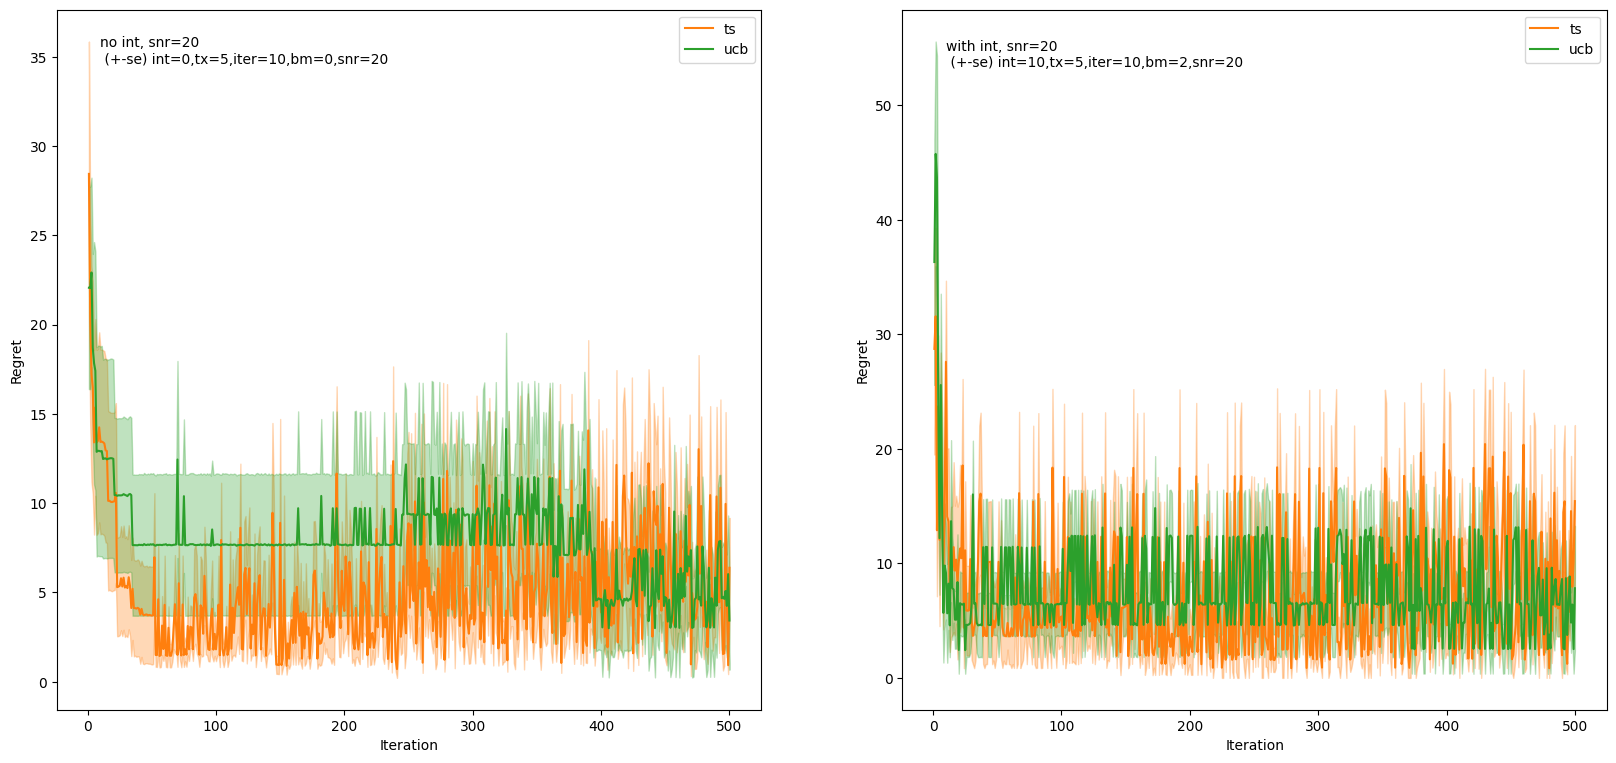

In [376]:
plotrun([1,2])

In [353]:
bkupresults(label="first_data",really=true)

In [ ]:
gresults = deserialize(resultfile("al_results.serialized"))

In [375]:
listresults()

1 ("no int, snr=20") :n_int=0,n_tx=5,n_iter=10,n_bm=0,snr=20,n_pt=500
2 ("with int, snr=20") :n_int=10,n_tx=5,n_iter=10,n_bm=2,snr=20,n_pt=500


In [370]:
clobberesult(2,really=true)

Done! But this won't become permanent until the next run. You can savef yourself with reloadgresults()1 ("with int, snr=20") :n_int=10,n_tx=5,n_iter=10,n_bm=2,snr=20,n_pt=500
